In [1]:
import subprocess as sp
import os
import silence_tensorflow.auto
import tensorflow as tf

def mask_unused_gpus(leave_unmasked=1):

  ACCEPTABLE_AVAILABLE_MEMORY = 1024
  COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"

  try:
    _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]
    memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    available_gpus = [i for i, x in enumerate(memory_free_values) if x > ACCEPTABLE_AVAILABLE_MEMORY]

    if len(available_gpus) < leave_unmasked: raise ValueError('Found only %d usable GPUs in the system' % len(available_gpus))
    gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
    tf.config.experimental.set_visible_devices(gpus[available_gpus[0]], 'GPU')
  
  except Exception as e:
    print('"nvidia-smi" is probably not installed. GPUs are not masked', e)

mask_unused_gpus()

In [2]:
import absl.logging
import matplotlib.pyplot as plt
import numpy as np
import shutil
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import IsolationForest
from tqdm import tqdm
absl.logging.set_verbosity(absl.logging.ERROR)

In [3]:
os.chdir('/home/ricky/RNNAE/conv_npy')

data_GP = np.array(np.load('lc.npy', allow_pickle=True))
data_meta_GP = np.array(np.load('lc_meta.npy', allow_pickle=True))

print(data_GP.shape)

(2970, 7, 96)


In [4]:
def create_input(rep=32, split_portion=0.8, num_of_type=1):

    claimedtype = []

    input = [ [] for i in range(num_of_type+1)]
    input_train = [ [] for i in range(num_of_type+1)]
    input_test = [ [] for i in range(num_of_type+1)]
    type_train = [ [] for i in range(num_of_type+1)]
    type_test = [ [] for i in range(num_of_type+1)]

    for i in range(len(data_meta_GP)):

        if 'Ia' in data_meta_GP[i]['type']:
                claimedtype.append(0)
        if 'IIP' in data_meta_GP[i]['type']:
                claimedtype.append(1)

    for i in range(len(claimedtype)):

        input[0].append(list(data_GP[i]))

        if claimedtype[i] == 0:
            input[1].append(list(data_GP[i]))
        if claimedtype[i] == 1:
            input[2].append(list(data_GP[i]))

    for i in range(len(input)):
      
        input[i] = np.array(input[i])

        print(i, input[i].shape)

        #set the peak to be day 0 again
        
        for j in range(input[i].shape[0]):
            m_max_id = np.argmin(input[i][j][2]) #find maximum by r band
            t_max = input[i][j][0][m_max_id]
            input[i][j][0] -= t_max


        #insert 0 in front of the list and then truncate the end
        for j in range(input[i].shape[0]):
            #print(input[i][j][0][0])
            for k in range(int(25+input[i][j][0][0])):
                for l in range(3):
                    #input[i][j][l+1] = np.insert(input[i][j][l+1], 0, input[i][j][l+1][0])[:96]
                    input[i][j][l+1] = np.insert(input[i][j][l+1], 0, 0)[:96]
                    #input[i][j][l+1] = input[i][j][l+1][0:100]
            

        #normalize np array along time by range
        '''for j in range(input[i].shape[0]):
            input[i][j,0,:] = input[i][j,0,:]/(np.max(input[i][j,0,:]) - np.min(input[i][j,0,:]))'''
        #print(i, input[i][:,0,:])

        input[i]       = K.cast_to_floatx(input[i].transpose((0, 2, 1)))
        input[i]       = np.repeat(input[i][:,:,1:-3], rep, axis=1)
        input[i]       = np.reshape(input[i],(input[i].shape[0], int(input[i].shape[1]/rep), int(input[i].shape[2]*rep), 1))

        input_train[i] = input[i][:int(split_portion*len(input[i])),:,:,:]
        input_test[i]  = input[i][int(split_portion*len(input[i])):,:,:,:]

        type_train[i]  = claimedtype[:int(split_portion*len(input[i]))]
        type_test[i]   = claimedtype[int(split_portion*len(input[i])):]

    for i in range(len(input)-1):
        print(f'For type {claimedtype[i]}, total size of data is {input[i].shape}, training size is {input_train[i].shape}, testing size is {input_test[i].shape}')

    return input, input_train, input_test, type_train, type_test

In [5]:
input, input_train, input_test, type_train, type_test = create_input()

0 (2970, 7, 96)
1 (2970, 7, 96)
For type 0, total size of data is (2970, 96, 96, 1), training size is (2376, 96, 96, 1), testing size is (594, 96, 96, 1)


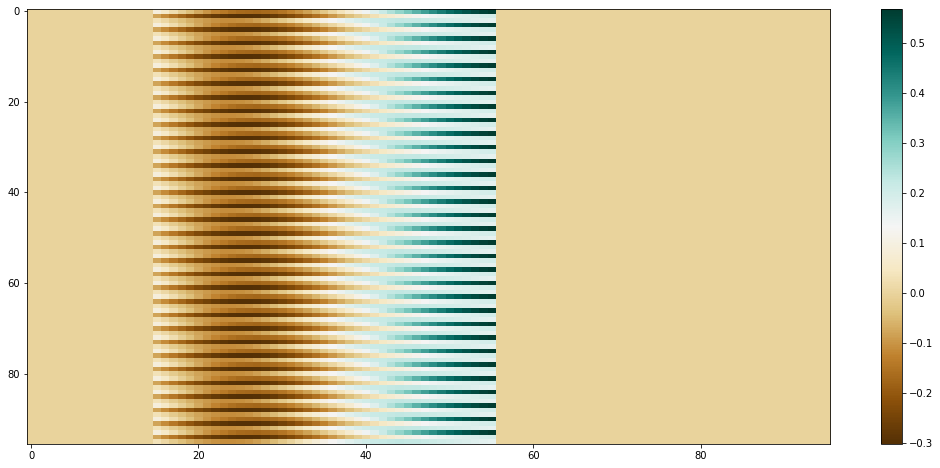

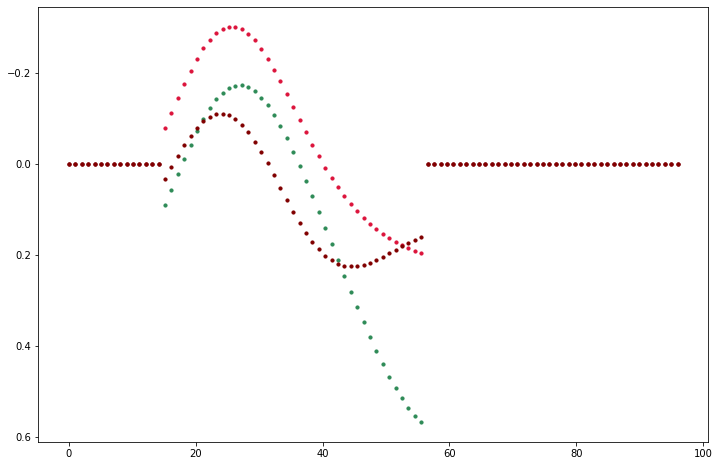

In [6]:
i = 1
fig = plt.figure(figsize=(18, 8))
pos = plt.imshow(input_train[0][i].reshape(96, 96).T, aspect='auto', cmap='BrBG')
fig.colorbar(pos)

fig = plt.figure(figsize=(12,8))
color1 = ['seagreen', 'crimson', 'maroon']
plt.gca().invert_yaxis()
for j in range(3):
    plt.scatter(np.linspace(0, 96, 96), input_train[0][i][:,j,:], s=10, marker='o', color=color1[j])

In [7]:
def cnnae(input, d=64):

    w = input[0].shape[1]
    h = input[0].shape[2]

    input_seq = keras.Input(shape=(w, h, 1))

    # Encoder
    x = layers.BatchNormalization()(input_seq)
    x = layers.Conv2D(d, (3, 3), activation=layers.LeakyReLU(), padding="same")(x) # 96*96*64
    x = layers.MaxPooling2D((2, 2), padding="same")(x) # 48*48*64
    x = layers.Conv2D(d, (3, 3), activation=layers.LeakyReLU(), padding="same")(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x) # 24*24*64
    x = layers.Conv2D(d, (3, 3), activation=layers.LeakyReLU(), padding="same")(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x) # 12*12*64
    x = layers.Conv2D(d, (3, 3), activation=layers.LeakyReLU(), padding="same")(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x) # 6*6*64
    x = layers.Conv2D(d, (3, 3), activation=layers.LeakyReLU(), padding="same")(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x) # 3*3*64
    x = layers.Conv2D(d, (3, 3), activation=layers.LeakyReLU(), padding="same")(x)
    x = layers.MaxPooling2D((3, 3), padding="same")(x) # 1*1*64
    x = layers.Flatten()(x) # 64
    x = layers.Dense(d, activation=layers.LeakyReLU())(x)
    encoded = layers.Dense(d//4, activation='linear')(x) #16

    # Decoder
    x = layers.Dense(d, activation=layers.LeakyReLU())(encoded) #64
    x = layers.Reshape((1, 1, d), input_shape=(d,))(x) # 1*1*64
    x = layers.Conv2DTranspose(d, (3, 3), strides=3, activation=layers.LeakyReLU(), padding="same")(x) # 3*3*64
    x = layers.Conv2DTranspose(d, (3, 3), strides=2, activation=layers.LeakyReLU(), padding="same")(x) # 6*6*64
    x = layers.Conv2DTranspose(d, (3, 3), strides=2, activation=layers.LeakyReLU(), padding="same")(x) # 12*12*64
    x = layers.Conv2DTranspose(d, (3, 3), strides=2, activation=layers.LeakyReLU(), padding="same")(x) # 24*24*64
    x = layers.Conv2DTranspose(d, (3, 3), strides=2, activation=layers.LeakyReLU(), padding="same")(x) # 48*48*64
    x = layers.Conv2DTranspose(d, (3, 3), strides=2, activation=layers.LeakyReLU(), padding="same")(x) # 96*96*64
    decoded = layers.Conv2D(1, (3, 3), activation="tanh", padding="same")(x)

    autoencoder = keras.Model(input_seq, decoded)
    encoder = keras.Model(input_seq, encoded)

    opt = Adam(learning_rate=0.0001)

    autoencoder.compile(optimizer=opt, loss="mse")
    print(autoencoder.summary())

    return autoencoder, encoder

def cnnae_train(autoencoder, input_tmp, patience=10, epochs=100):
    
    callbacks = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience,
                        verbose=0, mode='min', baseline=None,
                        restore_best_weights=True)

    history = autoencoder.fit(
                          x=input_tmp,
                          y=input_tmp,
                          validation_split = 0.1,
                          epochs=epochs,
                          verbose=2)
                          #callbacks=[callbacks])

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.grid()
    plt.ylim(0, 5e-3)

    os.chdir('/home/ricky/RNNAE')
    plt.show()
    #plt.savefig('CNN training history.pdf')

    return

In [15]:
def import_data(x):

    x = np.load(f'{x}.npy', allow_pickle=True)
    x = np.asarray(x).astype('float32')

    return x

def cnnae_test(autoencoder, input_tmp):

    pred = autoencoder.predict(x=input_tmp, verbose=1)
    pred_loss = autoencoder.evaluate(x=input_tmp, y=input_tmp, verbose=1)

    return pred, pred_loss

def latent_space_demo(encoder, input_tmp):

    latent_space = encoder.predict(input_tmp, verbose=1)
    
    os.chdir('/home/ricky/RNNAE/CNN_latent_space_graph')

    '''for i in range(latent_space.shape[1] - 1):
        for j in range(latent_space.shape[1] - 1 - i):
            fig = plt.figure(figsize=(6, 6))
            plt.grid()
            plt.scatter(latent_space[:,i], latent_space[:,i+j+1], s=8)
            plt.title(f'id {i} vs id {i+j+1}.pdf')
            plt.savefig(f'id_{i}_vs_id_{i+j+1}.pdf')
            plt.close()'''

    return latent_space

def isolation_forest(latent_space, n_tree, split):

    clf = IsolationForest(n_estimators=n_tree, warm_start=True)
    clf.fit(latent_space)
    anomaly = clf.score_samples(latent_space)
    anomaly_id = np.argsort(anomaly)

    shutil.rmtree('/home/ricky/RNNAE/CNN_product/CNN_anomaly_graph')
    os.makedirs('/home/ricky/RNNAE/CNN_product/CNN_anomaly_graph')

    for i, ano in enumerate(anomaly_id):
        name = data_meta_GP[ano+split]['SN_name']
        try:
            shutil.copy(f'/home/ricky/RNNAE/SDSS_GP_graph/{name}.pdf', f'/home/ricky/RNNAE/CNN_product/CNN_anomaly_graph/{i}_{name}.pdf')
        except:
            shutil.copy(f'/home/ricky/RNNAE/SDSS_prime_GP_graph/{name}.pdf', f'/home/ricky/RNNAE/CNN_product/CNN_anomaly_graph/{i}_{name}.pdf')

    return

def reconstruction_graph(input_tmp, pred, split, filters=['g', 'r', 'i']):

    color1 = ['seagreen', 'crimson', 'maroon']
    color2 = ['darkgreen', 'firebrick', 'darkred']

    shutil.rmtree('/home/ricky/RNNAE/CNN_product/CNN_reconstruction_graph')
    os.makedirs('/home/ricky/RNNAE/CNN_product/CNN_reconstruction_graph')

    for i in tqdm(range(input_tmp.shape[0])):

        os.chdir('/home/ricky/RNNAE/CNN_product/CNN_reconstruction_graph')

        isExist = os.path.exists(f'./{data_meta_GP[i+split]["SN_name"]}')

        if not isExist:
            os.makedirs(f'./{data_meta_GP[i+split]["SN_name"]}')
            os.chdir(f'./{data_meta_GP[i+split]["SN_name"]}')

        fig, axs = plt.subplots(3, figsize=(15, 20))

        fig.suptitle('Images of CNN')
        axs[0].set_title('input test image')
        axs[1].set_title('reconstructed test image')
        axs[2].set_title('difference')

        a0 = axs[0].imshow(input_test[0][i].reshape(96,96).T, interpolation='nearest', aspect='auto', cmap='BrBG')
        a1 = axs[1].imshow(pred[i].reshape(96,96).T, interpolation='nearest', aspect='auto', cmap='BrBG')
        a2 = axs[2].imshow((input_test[0][i] - pred[i]).reshape(96,96).T, interpolation='nearest', aspect='auto', cmap='BrBG')

        fig.colorbar(a0, ax=axs[0])
        fig.colorbar(a1, ax=axs[1])
        fig.colorbar(a2, ax=axs[2])

        #plt.show()
        fig.savefig(f'./{data_meta_GP[i]["SN_name"]}.pdf', bbox_inches='tight')

        plt.close()

        color1 = ['seagreen', 'crimson', 'maroon']
        color2 = ['darkgreen', 'firebrick', 'darkred']

        for j, filter in enumerate(filters):
            fig = plt.figure(figsize=(12, 8))
            ax = fig.add_subplot(1, 1, 1)

            plt.gca().invert_yaxis()

            # And a corresponding grid
            ax.grid(which='major', alpha=0.8)
            ax.grid(which='minor', alpha=0.3)

            plt.xlabel('Timestep', fontsize=15)
            plt.ylabel('Absolute Magnitude', fontsize=15)

            plt.title(f'{data_meta_GP[i+split]["SN_name"]}, {data_meta_GP[i+split]["type"]}, {filter}')

            #plt.errorbar(data_GP[i+split][0], data_GP[i+split][j+1], y_err=data_GP[i+split][j+4], fmt='v')

            plt.scatter(np.linspace(0, 96, 96), input_test[0][i][:,j,:], s=2, marker='o', color=color1[j], label=f'test data'.format('o'))
            plt.scatter(np.linspace(0, 96, 96), pred[i][:,j,:], s=12, marker='X', color=color2[j], label=f'reconstruction'.format('X'))
            
            plt.legend()

            #plt.show()
            plt.savefig(f'./{data_meta_GP[i+split]["SN_name"]}_{filter}_band.pdf')

            plt.close()

    return

def cnn_predict(autoencoder, encoder, input_tmp, **kwargs):

    split = int(0.8*(data_GP.shape[0]))

    if kwargs['training_data']:
        split = 0

    pred, pred_loss = cnnae_test(autoencoder, input_tmp)

    if kwargs['reconstruct_graph']:
        print('Plotting reconstruction graphs...')
        reconstruction_graph(input_tmp, pred, split)

    return pred, pred_loss

0 (2970, 7, 96)
1 (2970, 7, 96)
For type 0, total size of data is (2970, 96, 96, 1), training size is (2376, 96, 96, 1), testing size is (594, 96, 96, 1)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 96, 96, 1)]       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 96, 96, 64)        640       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 2

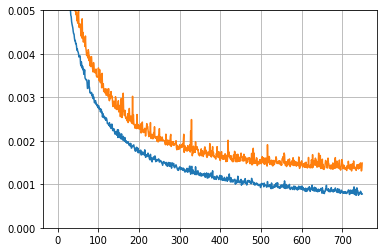

19/19 [==============================] - 0s 9ms/step - loss: 0.0017
pred_loss_total is 0.0016793854301795363


"autoencoder.save('/home/ricky/RNNAE/CNN_autoencoder_model')\nencoder.save('/home/ricky/RNNAE/CNN_encoder_model')"

In [11]:
input, input_train, input_test, type_train, type_test = create_input(rep=32)

os.chdir('/home/ricky/RNNAE/CNN_product/CNN_npy')
np.save('input.npy', np.array(input, dtype=object))
np.save('input_train.npy', np.array(input_train, dtype=object))
np.save('input_test.npy', np.array(input_test, dtype=object))
np.save('type_train.npy', np.array(type_train, dtype=object))
np.save('type_test.npy', np.array(type_test, dtype=object))

pred_loss_total = 0

for i in range(1):
    
    autoencoder, encoder = cnnae(input, d=64)
    cnnae_train(autoencoder, input_train[0], epochs=750)
    pred, pred_loss = cnn_predict(autoencoder, encoder, input_test[0], reconstruct_graph=False, training_data=False)

    pred_loss_total += pred_loss

print('pred_loss_total is', pred_loss_total)

'''autoencoder.save('/home/ricky/RNNAE/CNN_autoencoder_model')
encoder.save('/home/ricky/RNNAE/CNN_encoder_model')'''

In [16]:
split = int(0.8*(data_GP.shape[0]))
reconstruction_graph(input_test[0], pred, split)

100%|██████████| 594/594 [12:33<00:00,  1.27s/it]


In [17]:
latent_space = encoder.predict(input[0], verbose=1)
#latent_space = encoder.predict(input_test[0], verbose=1).T
print(latent_space.shape)

'''import sklearn.manifold as m

embedded = m.TSNE(n_components=2).fit_transform(latent_space).T
print(embedded.shape)
plt.scatter(embedded[0], embedded[1], s=6)
plt.show()'''

d = '/home/ricky/RNNAE/CNN_product/CNN_latent_space_graph'

isExist = os.path.exists(d)
if isExist:
    shutil.rmtree(d)
    os.makedirs(d)
else:
    os.makedirs(d)

os.chdir(d)

for i in range(latent_space.shape[1] - 1):
        for j in range(latent_space.shape[1] - 1 - i):
            fig = plt.figure(figsize=(6, 6))
            plt.grid()
            plt.scatter(latent_space[:,i], latent_space[:,i+j+1], s=6)
            plt.title(f'id {i} vs id {i+j+1}')
            #plt.show()
            plt.savefig(f'id_{i}_vs_id_{i+j+1}.pdf')
            plt.close()

93/93 [==============================] - 0s 4ms/step
(2970, 16)


In [19]:
isolation_forest(latent_space, 1000, split=0)